## Nota sobre los cambios respecto al notebook original

En esta versión del proyecto, he realizado varios cambios respecto al código base proporcionado:

- **Uso de Polars en vez de pandas:**  
  He optado por seguir utilizando Polars para la manipulación de datos en Python, ya que es una librería más eficiente y rápida para grandes volúmenes de datos, además de ofrecer una sintaxis moderna y muy potente para análisis y transformaciones.

- **Conexión a la base de datos con SQLAlchemy:**  
  En lugar de conectores más simples como `mysql-connector` o `pymysql`, sigo utilizando SQLAlchemy, que es más flexible y profesional, y permite una mejor gestión de conexiones, transacciones y portabilidad del código.

- **Gestión de credenciales con dotenv:**  
  Para evitar exponer contraseñas y parámetros sensibles en el código, he usado la librería `python-dotenv` y guardo los datos de conexión en un archivo `.env`, que está excluido del repositorio con `.gitignore` para mayor seguridad.

- **Manejo de errores y código más robusto:**  
  Se ha añadido control de errores y mensajes informativos en las funciones de consulta para asegurar que cualquier fallo en la conexión o en las queries sea fácil de identificar y depurar, acción que ayuda mucho para identificar errores de todo tipo.

En definitiva, estos cambios son para seguir un poco la lógica del primer notebook, y seguir usando las mismas librerías y dependencias.


In [1]:
# Importamos todas las dependencias necesarias (a priori)

import pandas as pd
import numpy as np
import polars as pl

from dotenv import load_dotenv
import os

import datetime

from meteostat import Point, Daily
import sqlalchemy as sa
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno

## 1. Consulta a la base de datos

In [2]:
# Paso hecho anteriormente en el notebook 02, he visto que aquí también está así que vuelvo a hacer este paso
class DatabaseConnection:

    # Información necesaria para establecer la conexión a la BBDD
    def __init__(self):
        load_dotenv()  # Variables de entorno
        port = 3306  # Puerto por defecto de MySQL
        user = os.getenv("DB_USER")
        password = os.getenv("DB_PASSWORD")
        host = os.getenv("DB_HOST")
        nombre_base_datos = os.getenv("DB_NAME") 
        self.engine = create_engine(
            f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{nombre_base_datos}"
        )

    # Función cuyo cometido es consultar una query a la BBDD y devolverla como un dataframe de Polars
    def query_to_polars(self, sql_query):
        try:
            with self.engine.connect() as conn:
                result = conn.execute(text(sql_query))
                columns = result.keys()
                rows = result.fetchall()
                if not rows:
                    print("Consulta ejecutada correctamente pero no hay resultados.")
                    return pl.DataFrame(schema=columns)
                print("Consulta ejecutada correctamente.")
                return pl.DataFrame(rows, schema=columns)
        except SQLAlchemyError as e:
            print(f"Error de SQLAlchemy al ejecutar la consulta:\{e}")
            return None
        except Exception as e:
            print(f"Error inesperado:\{e}")
            return None

# Usamos y probamos la clase
db = DatabaseConnection()

query = """
SELECT *
FROM ventas_diarias_estudio
WHERE ARTICULO = '3960'
"""

ventas_prueba = db.query_to_polars(query)
ventas_prueba




Consulta ejecutada correctamente.


familia,tipo,fechaVenta,festivo,articulo,precio,orden_articulo_familia,in_fecha_estudio,cantidad,importe
str,str,date,str,str,f64,i64,str,f64,f64
"""BOLLERIA""","""VENTA""",2021-05-01,null,"""3960""",2.318,1,"""S""",2814.0,6522.851963
"""BOLLERIA""","""VENTA""",2021-05-02,"""Día de la Madre""","""3960""",2.318,1,"""S""",2583.0,5987.393973
"""BOLLERIA""","""VENTA""",2021-05-03,"""Día de la Cruz""","""3960""",2.318,1,"""S""",1596.0,3699.527961
"""BOLLERIA""","""VENTA""",2021-05-04,null,"""3960""",2.318,1,"""S""",1659.0,3845.561991
"""BOLLERIA""","""VENTA""",2021-05-05,null,"""3960""",2.318,1,"""S""",2016.0,4673.088001
…,…,…,…,…,…,…,…,…,…
"""BOLLERIA""","""VENTA""",2023-04-26,null,"""3960""",3.273,1,"""S""",1134.0,3711.582092
"""BOLLERIA""","""VENTA""",2023-04-27,null,"""3960""",3.273,1,"""S""",1512.0,4948.776123
"""BOLLERIA""","""VENTA""",2023-04-28,null,"""3960""",3.273,1,"""S""",1281.0,4192.713104


In [3]:
# La Query está adaptada, usa mi base y mi tabla correcta (nombre)
# IMP: se omiten las columnas irrelevantes -> 'in_fecha_estudio' y 'tipo'
query_daily_and_top = """
SELECT  familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

FROM ventas_diarias_estudio_completo
"""
# !!ESCRIBIR EL "COMPLETO"!! tenia errores en la carga de datos por no añadir el "completo" en la consulta SQL

# Instanciar la clase con la contraseña de la BBDD (mejor ocultar la contraseña)
db = DatabaseConnection()

# Consultar la query anterior y devolverla como un dataframe de Polars
ventas = db.query_to_polars(query_daily_and_top)

# Convertir 'articulo' a entero en Polars, ya cambié el formato a "Date" al insertar las tablas en el primer notebook
ventas = ventas.with_columns([
    pl.col("articulo").cast(pl.Int64)
])

Consulta ejecutada correctamente.


In [4]:
ventas

familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
str,i64,date,str,f64,f64,f64,i64
"""BOLLERIA""",3880,2021-05-01,null,2.591,1995.0,5169.044983,3
"""BOLLERIA""",3960,2021-05-01,null,2.318,2814.0,6522.851963,1
"""BOLLERIA""",5803,2021-05-01,null,2.727,1659.0,4524.092865,5
"""BOLLERIA""",6286,2021-05-01,null,3.136,1155.0,3622.080044,4
"""BOLLERIA""",6425,2021-05-01,null,31.364,222.074997,6965.154583,2
…,…,…,…,…,…,…,…
"""PASTELERIA""",6523,2023-05-17,null,40.772999,84.0,3424.932007,3
"""PASTELERIA""",5403,2023-05-18,null,40.772999,54.600001,2226.203049,2
"""PASTELERIA""",5404,2023-05-18,null,43.5,126.0,5481.0,1


In [5]:
# Voy a realizar una comprobación de los tipos de las columnas (experimentación con Polars)

for col, dtype in zip(ventas.columns, ventas.dtypes):
    print(f"{col}: {dtype}")

familia: String
articulo: Int64
fecha_venta: Date
festivo: String
precio: Float64
cantidad: Float64
importe: Float64
orden_articulo_familia: Int64


In [6]:
# Compruebo la columna festivo, no recordaba el formato y ahora veo el porqué del "String"
print(ventas["festivo"].head(10))

shape: (10,)
Series: 'festivo' [str]
[
	null
	null
	null
	null
	null
	"Día de la Madre"
	"Día de la Madre"
	"Día de la Madre"
	"Día de la Madre"
	"Día de la Madre"
]


In [7]:
# El método ".select" sería lo correcto con Polars
print(ventas.select("festivo").unique())

shape: (27, 1)
┌─────────────────────────┐
│ festivo                 │
│ ---                     │
│ str                     │
╞═════════════════════════╡
│ Día del Padre           │
│ Domingo de Resurrección │
│ Miércoles Santo         │
│ Nochevieja              │
│ Día de San Valentín     │
│ …                       │
│ Martes Santo            │
│ Día de la Cruz          │
│ Día de San Juan         │
│ Navidad                 │
│ Lunes Santo             │
└─────────────────────────┘


## 2. Consulta a [meteostat API](https://dev.meteostat.net/python/daily.html)

Variables que se obtienen:

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [8]:
class DailyWeatherData:

    # Localización de la tienda de la Panadería Salvador Echeverría
    ECHEVERRIA_SHOP = Point(36.721477644071705, -4.363132134392174)

    # Columnas identificadas como importantes
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definición del horizonte temporal de la consulta a la API
    def __init__(self, start, end=None):
        self.start = DailyWeatherData._to_datetime(start)
        if end is not None:
            self.end = DailyWeatherData._to_datetime(end)
        else:
            self.end = datetime.datetime.now()

    # He tenido errores de formato datetime.datetime y datetime.date (end y start), con la siguiente función soluciono el problema (creo que es tema de usar Polars)
    @staticmethod  # Uso un @staticmethod para llamar la clase directamente sin necesidad de crear un objeto antes
    def _to_datetime(dt):
        if isinstance(dt, datetime.datetime):
            return dt
        if isinstance(dt, datetime.date):  # Si es datetime.date, convierto SIEMPRE a datetime.datetime
            return datetime.datetime(dt.year, dt.month, dt.day)
        if hasattr(dt, "to_pydatetime"):  # Por si es Polars
            res = dt.to_pydatetime()
            # Por si meteostat devuelve date igualmente
            if isinstance(res, datetime.date) and not isinstance(res, datetime.datetime):
                return datetime.datetime(res.year, res.month, res.day)
            return res
        raise TypeError(f"No puedo convertir {dt} a datetime.datetime")

    # Se establece que la consulta será diaria, se seleccionan todas las columnas imps y se añade un suff.
    def get_weather_data(self, as_polars=True):   # Añado un argumento extra, recibiré un df de Pandas y tengo que convertirlo a Polars
        start_dt = self._to_datetime(self.start)
        end_dt = self._to_datetime(self.end)
        print("start_dt:", start_dt, type(start_dt))
        print("end_dt:", end_dt, type(end_dt))
        daily_data = Daily(self.ECHEVERRIA_SHOP, start_dt, end_dt)
        data = daily_data.fetch()  # Aquí devuelve un df de Pandas
        df = data[self.IMP_COLUMNS]
        df.columns = [f"{col}_w" for col in df.columns]  # Añado el sufijo para evitar conflictos con algun merge (w=weather)
        df = df.reset_index()
        # Aquí cambio a Polars
        if as_polars:
            return pl.from_pandas(df)
        else:
            return df
        
        


### Nota sobre fechas y compatibilidad Polars/Meteostat

Al trabajar con **Polars** para el análisis y luego tirar de la API de **Meteostat** para meter datos de tiempo, he tenido que pelearme un poco con los tipos de fecha.

- Cuando sacas el mínimo o máximo de una columna de fechas con Polars, lo que te devuelve es un **`datetime.date`**.
- Pero la librería Meteostat, para sus consultas, quiere **sí o sí un `datetime.datetime`** (no es lo mismo), porque por dentro resta con `datetime.now()` (que es `datetime.datetime`).

¿El resultado si no lo conviertes? Te comes un error del tipo:

TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'datetime.date'

Con pandas este problema sale menos, porqué suele devolver un tipo de fecha más compatible, pero aun así puede pasar.  
Por eso, lo más seguro es **convertir todo a `datetime.datetime` antes de llamar a Meteostat**, y así te ahorras sustos y funciona todo bien, uses la librería que uses para tus datos.

> **Resumen**:  
> Si mezclas varias librerías, revisa siempre qué tipo de fecha manejas antes de combinarlas… así te evitas quebraderos de cabeza como este 😉



In [9]:
start_ventas = ventas["fecha_venta"].min()
end_ventas = ventas["fecha_venta"].max()

print(start_ventas)
print(end_ventas)

2021-05-01
2023-05-18


In [10]:
# Vamos a usar las fechas de inicio y fin dónde haya ventas
start_date = datetime.date(2021, 5, 1)
end_date = datetime.date(2023, 5, 18)

weather_getter = DailyWeatherData(start=start_date, end=end_date)
weather = weather_getter.get_weather_data(as_polars=True)
weather



start_dt: 2021-05-01 00:00:00 <class 'datetime.datetime'>
end_dt: 2023-05-18 00:00:00 <class 'datetime.datetime'>


time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
datetime[ns],f64,f64,f64,f64,f64,f64,f64
2021-05-01 00:00:00,17.2,11.9,22.8,0.0,null,14.2,1014.0
2021-05-02 00:00:00,16.3,10.8,23.2,0.0,null,15.7,1015.9
2021-05-03 00:00:00,15.3,12.7,20.1,6.5,null,9.7,1017.7
2021-05-04 00:00:00,16.5,12.0,20.9,0.0,null,12.1,1018.0
2021-05-05 00:00:00,16.7,12.3,21.7,0.0,null,13.8,1016.5
…,…,…,…,…,…,…,…
2023-05-14 00:00:00,19.4,14.1,25.5,0.0,null,12.6,1018.2
2023-05-15 00:00:00,23.8,15.9,32.0,0.0,null,15.5,1015.5
2023-05-16 00:00:00,22.3,17.8,26.2,0.0,null,17.6,1013.0


In [11]:
print(weather.head(5))
print(weather.tail(5))

shape: (5, 8)
┌─────────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ time                ┆ tavg_w ┆ tmin_w ┆ tmax_w ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---                 ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ datetime[ns]        ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞═════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ 2021-05-01 00:00:00 ┆ 17.2   ┆ 11.9   ┆ 22.8   ┆ 0.0    ┆ null   ┆ 14.2   ┆ 1014.0 │
│ 2021-05-02 00:00:00 ┆ 16.3   ┆ 10.8   ┆ 23.2   ┆ 0.0    ┆ null   ┆ 15.7   ┆ 1015.9 │
│ 2021-05-03 00:00:00 ┆ 15.3   ┆ 12.7   ┆ 20.1   ┆ 6.5    ┆ null   ┆ 9.7    ┆ 1017.7 │
│ 2021-05-04 00:00:00 ┆ 16.5   ┆ 12.0   ┆ 20.9   ┆ 0.0    ┆ null   ┆ 12.1   ┆ 1018.0 │
│ 2021-05-05 00:00:00 ┆ 16.7   ┆ 12.3   ┆ 21.7   ┆ 0.0    ┆ null   ┆ 13.8   ┆ 1016.5 │
└─────────────────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘
shape: (5, 8)
┌──────────────

In [12]:
# Para ver los nulos con Polars es algo más complejo, esta es la metodología
nulls_column = weather.select([
    pl.col(col).null_count().alias(col) for col in weather.columns
    ])

print(nulls_column)


shape: (1, 8)
┌──────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ time ┆ tavg_w ┆ tmin_w ┆ tmax_w ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---  ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ u32  ┆ u32    ┆ u32    ┆ u32    ┆ u32    ┆ u32    ┆ u32    ┆ u32    │
╞══════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ 0    ┆ 0      ┆ 0      ┆ 0      ┆ 7      ┆ 748    ┆ 0      ┆ 0      │
└──────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘


In [13]:
# Días en qué hay valores nulos
days_with_nulls = weather.filter(
    pl.any_horizontal([pl.col(c).is_null() for c in weather.columns])
    )
print(days_with_nulls)

# Se entiende que todos, ya que la dirección del viento es nula en todas las filas

shape: (748, 8)
┌─────────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ time                ┆ tavg_w ┆ tmin_w ┆ tmax_w ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---                 ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ datetime[ns]        ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞═════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ 2021-05-01 00:00:00 ┆ 17.2   ┆ 11.9   ┆ 22.8   ┆ 0.0    ┆ null   ┆ 14.2   ┆ 1014.0 │
│ 2021-05-02 00:00:00 ┆ 16.3   ┆ 10.8   ┆ 23.2   ┆ 0.0    ┆ null   ┆ 15.7   ┆ 1015.9 │
│ 2021-05-03 00:00:00 ┆ 15.3   ┆ 12.7   ┆ 20.1   ┆ 6.5    ┆ null   ┆ 9.7    ┆ 1017.7 │
│ 2021-05-04 00:00:00 ┆ 16.5   ┆ 12.0   ┆ 20.9   ┆ 0.0    ┆ null   ┆ 12.1   ┆ 1018.0 │
│ 2021-05-05 00:00:00 ┆ 16.7   ┆ 12.3   ┆ 21.7   ┆ 0.0    ┆ null   ┆ 13.8   ┆ 1016.5 │
│ …                   ┆ …      ┆ …      ┆ …      ┆ …      ┆ …      ┆ …      ┆ …      │
│ 2023-05-14 00:00:00 ┆ 19.

In [14]:
# Fechas específicas dónde hay valores nulos en "prcp_w"
prcp_null = weather.filter(pl.col("prcp_w").is_null())  
print(prcp_null[["time", "prcp_w"]])


shape: (7, 2)
┌─────────────────────┬────────┐
│ time                ┆ prcp_w │
│ ---                 ┆ ---    │
│ datetime[ns]        ┆ f64    │
╞═════════════════════╪════════╡
│ 2021-10-26 00:00:00 ┆ null   │
│ 2021-10-30 00:00:00 ┆ null   │
│ 2022-01-27 00:00:00 ┆ null   │
│ 2022-02-28 00:00:00 ┆ null   │
│ 2022-03-05 00:00:00 ┆ null   │
│ 2022-04-26 00:00:00 ┆ null   │
│ 2022-04-27 00:00:00 ┆ null   │
└─────────────────────┴────────┘


In [15]:
# Vemos todas las columnas de los días dónde las precipitaciones són nulas
print(prcp_null)

shape: (7, 8)
┌─────────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ time                ┆ tavg_w ┆ tmin_w ┆ tmax_w ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---                 ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ datetime[ns]        ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞═════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ 2021-10-26 00:00:00 ┆ 18.3   ┆ 15.6   ┆ 24.1   ┆ null   ┆ null   ┆ 9.6    ┆ 1020.4 │
│ 2021-10-30 00:00:00 ┆ 21.8   ┆ 17.6   ┆ 26.8   ┆ null   ┆ null   ┆ 6.8    ┆ 1014.6 │
│ 2022-01-27 00:00:00 ┆ 15.2   ┆ 14.0   ┆ 16.3   ┆ null   ┆ null   ┆ 29.2   ┆ 1024.9 │
│ 2022-02-28 00:00:00 ┆ 13.6   ┆ 10.9   ┆ 17.0   ┆ null   ┆ null   ┆ 9.6    ┆ 1026.8 │
│ 2022-03-05 00:00:00 ┆ 13.9   ┆ 7.9    ┆ 19.2   ┆ null   ┆ null   ┆ 12.4   ┆ 1016.2 │
│ 2022-04-26 00:00:00 ┆ 16.3   ┆ 13.5   ┆ 21.4   ┆ null   ┆ null   ┆ 8.7    ┆ 1013.8 │
│ 2022-04-27 00:00:00 ┆ 16.2 

In [ ]:
# Ruta para guardar archivos de datos ya procesados
PROCESSED_DATA_DIR = r"d:\PersonalProjects\Panadería Datathon\data\processed"

# Voy a convertir el archivo a csv también, ya que Polars tiene método directo
weather.write_csv(os.path.join(PROCESSED_DATA_DIR, "variables_meteorologicas.csv"))

# En Polars no hay método directo para convertir a Excel, así que primero a Pandas
weather_pandas = weather.to_pandas()

weather_pandas.to_excel(os.path.join(PROCESSED_DATA_DIR, "variables_meteorologicas.xlsx"))



## 3. Join -> Datos de ventas y del tiempo

In [17]:
ventas

familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
str,i64,date,str,f64,f64,f64,i64
"""BOLLERIA""",3880,2021-05-01,null,2.591,1995.0,5169.044983,3
"""BOLLERIA""",3960,2021-05-01,null,2.318,2814.0,6522.851963,1
"""BOLLERIA""",5803,2021-05-01,null,2.727,1659.0,4524.092865,5
"""BOLLERIA""",6286,2021-05-01,null,3.136,1155.0,3622.080044,4
"""BOLLERIA""",6425,2021-05-01,null,31.364,222.074997,6965.154583,2
…,…,…,…,…,…,…,…
"""PASTELERIA""",6523,2023-05-17,null,40.772999,84.0,3424.932007,3
"""PASTELERIA""",5403,2023-05-18,null,40.772999,54.600001,2226.203049,2
"""PASTELERIA""",5404,2023-05-18,null,43.5,126.0,5481.0,1


In [18]:
weather

time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
datetime[ns],f64,f64,f64,f64,f64,f64,f64
2021-05-01 00:00:00,17.2,11.9,22.8,0.0,null,14.2,1014.0
2021-05-02 00:00:00,16.3,10.8,23.2,0.0,null,15.7,1015.9
2021-05-03 00:00:00,15.3,12.7,20.1,6.5,null,9.7,1017.7
2021-05-04 00:00:00,16.5,12.0,20.9,0.0,null,12.1,1018.0
2021-05-05 00:00:00,16.7,12.3,21.7,0.0,null,13.8,1016.5
…,…,…,…,…,…,…,…
2023-05-14 00:00:00,19.4,14.1,25.5,0.0,null,12.6,1018.2
2023-05-15 00:00:00,23.8,15.9,32.0,0.0,null,15.5,1015.5
2023-05-16 00:00:00,22.3,17.8,26.2,0.0,null,17.6,1013.0


In [19]:
# Las columnas de join tienen que tener el mismo tipo, "fecha_venta" y "time"
ventas = ventas.with_columns(pl.col("fecha_venta").cast(pl.Date))

# El método .cast en Polars, convierte las columnas en el tipo que le indicamos
weather = weather.with_columns(pl.col("time").cast(pl.Date))

df_join = ventas.join(
    weather,
    left_on="fecha_venta",
    right_on="time",
    how="inner"
)

    

# Ordenar el df por "articulo" y la "fecha_venta"
df = df_join.sort(["articulo", "fecha_venta"])
df.head(5)

familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,i64,date,str,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""PANADERIA""",417,2021-05-01,null,4.038,504.0,2035.152027,5,17.2,11.9,22.8,0.0,null,14.2,1014.0
"""PANADERIA""",417,2021-05-02,"""Día de la Madre""",4.038,567.0,2289.545967,5,16.3,10.8,23.2,0.0,null,15.7,1015.9
"""PANADERIA""",417,2021-05-03,"""Día de la Cruz""",4.038,630.0,2543.939987,5,15.3,12.7,20.1,6.5,null,9.7,1017.7
"""PANADERIA""",417,2021-05-04,null,4.038,588.0,2374.344009,5,16.5,12.0,20.9,0.0,null,12.1,1018.0
"""PANADERIA""",417,2021-05-05,null,4.038,588.0,2374.344023,5,16.7,12.3,21.7,0.0,null,13.8,1016.5


## 4. EDA

#### 4.1. Inspección inicial

Este apartado tiene como cometido comprender la estructura del conjunto de datos y ver posibles problemas de calidad que podrían afectar al análisis.

**Grupo de preguntas 1** (x minutos):

1. Describe que significa cada fila de nuestro conjunto de datos.

2. ¿Cuántos valores únicos hay en cada una de las variables? ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?

3. ¿Cuántos valores nulos hay en cada una de las variables?

4. ¿Hay duplicados?

In [65]:
# 1
example = df.head(1)
display(example)

familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,i64,date,str,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""PANADERIA""",417,2021-05-01,null,4.038,504.0,2035.152027,5,17.2,11.9,22.8,0.0,null,14.2,1014.0


In [ ]:
# 1
print(df.schema)

Schema([('familia', String), ('articulo', Int64), ('fecha_venta', Date), ('festivo', String), ('precio', Float64), ('cantidad', Float64), ('importe', Float64), ('orden_articulo_familia', Int64), ('tavg_w', Float64), ('tmin_w', Float64), ('tmax_w', Float64), ('prcp_w', Float64), ('wdir_w', Float64), ('wspd_w', Float64), ('pres_w', Float64)])


**Cada fila del conjunto de datos representa las ventas de un artículo concreto en un día determinado en la Panadería Salvador, incluyendo información de la venta y variables meteorológicas asociadas a ese día.**

In [ ]:
# 2_Valores únicos por variable  (Seguimos con Polars)
{col: df[col].n_unique() for col in df.columns}

{'familia': 3,
 'articulo': 15,
 'fecha_venta': 748,
 'festivo': 27,
 'precio': 65,
 'cantidad': 1418,
 'importe': 6303,
 'orden_articulo_familia': 5,
 'tavg_w': 200,
 'tmin_w': 214,
 'tmax_w': 221,
 'prcp_w': 60,
 'wdir_w': 1,
 'wspd_w': 197,
 'pres_w': 217}

In [ ]:
# 2_Relación "artículo" y "precio", para ver precios distintos que ha tenido cada artículo
prices_item = df.group_by("articulo").agg([
    pl.col("precio").n_unique().alias("precios_unicos")
]).sort("precios_unicos", descending=True)

prices_item.head(10)

# Haciendo la comparación entre precios únicos y "artículo", vemos como el precio ha cambiado a lo largo del tiempo

# Si algún artículo tiene más de un precio único, indica que su precio ha variado


articulo,precios_unicos
i64,u32
6425,24
5404,7
968,5
1043,5
5403,5
6286,5
417,4
1084,4
3880,4


In [ ]:
# 3_Vamos a ver los valores nulos por columna
nulls_per_column = df.select([
    pl.col(col).null_count().alias(col) for col in df.columns
])
print(nulls_per_column)

shape: (1, 15)
┌─────────┬──────────┬─────────────┬─────────┬───┬────────┬────────┬────────┬────────┐
│ familia ┆ articulo ┆ fecha_venta ┆ festivo ┆ … ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---     ┆ ---      ┆ ---         ┆ ---     ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ u32     ┆ u32      ┆ u32         ┆ u32     ┆   ┆ u32    ┆ u32    ┆ u32    ┆ u32    │
╞═════════╪══════════╪═════════════╪═════════╪═══╪════════╪════════╪════════╪════════╡
│ 0       ┆ 0        ┆ 0           ┆ 9737    ┆ … ┆ 97     ┆ 10574  ┆ 0      ┆ 0      │
└─────────┴──────────┴─────────────┴─────────┴───┴────────┴────────┴────────┴────────┘


<Axes: >

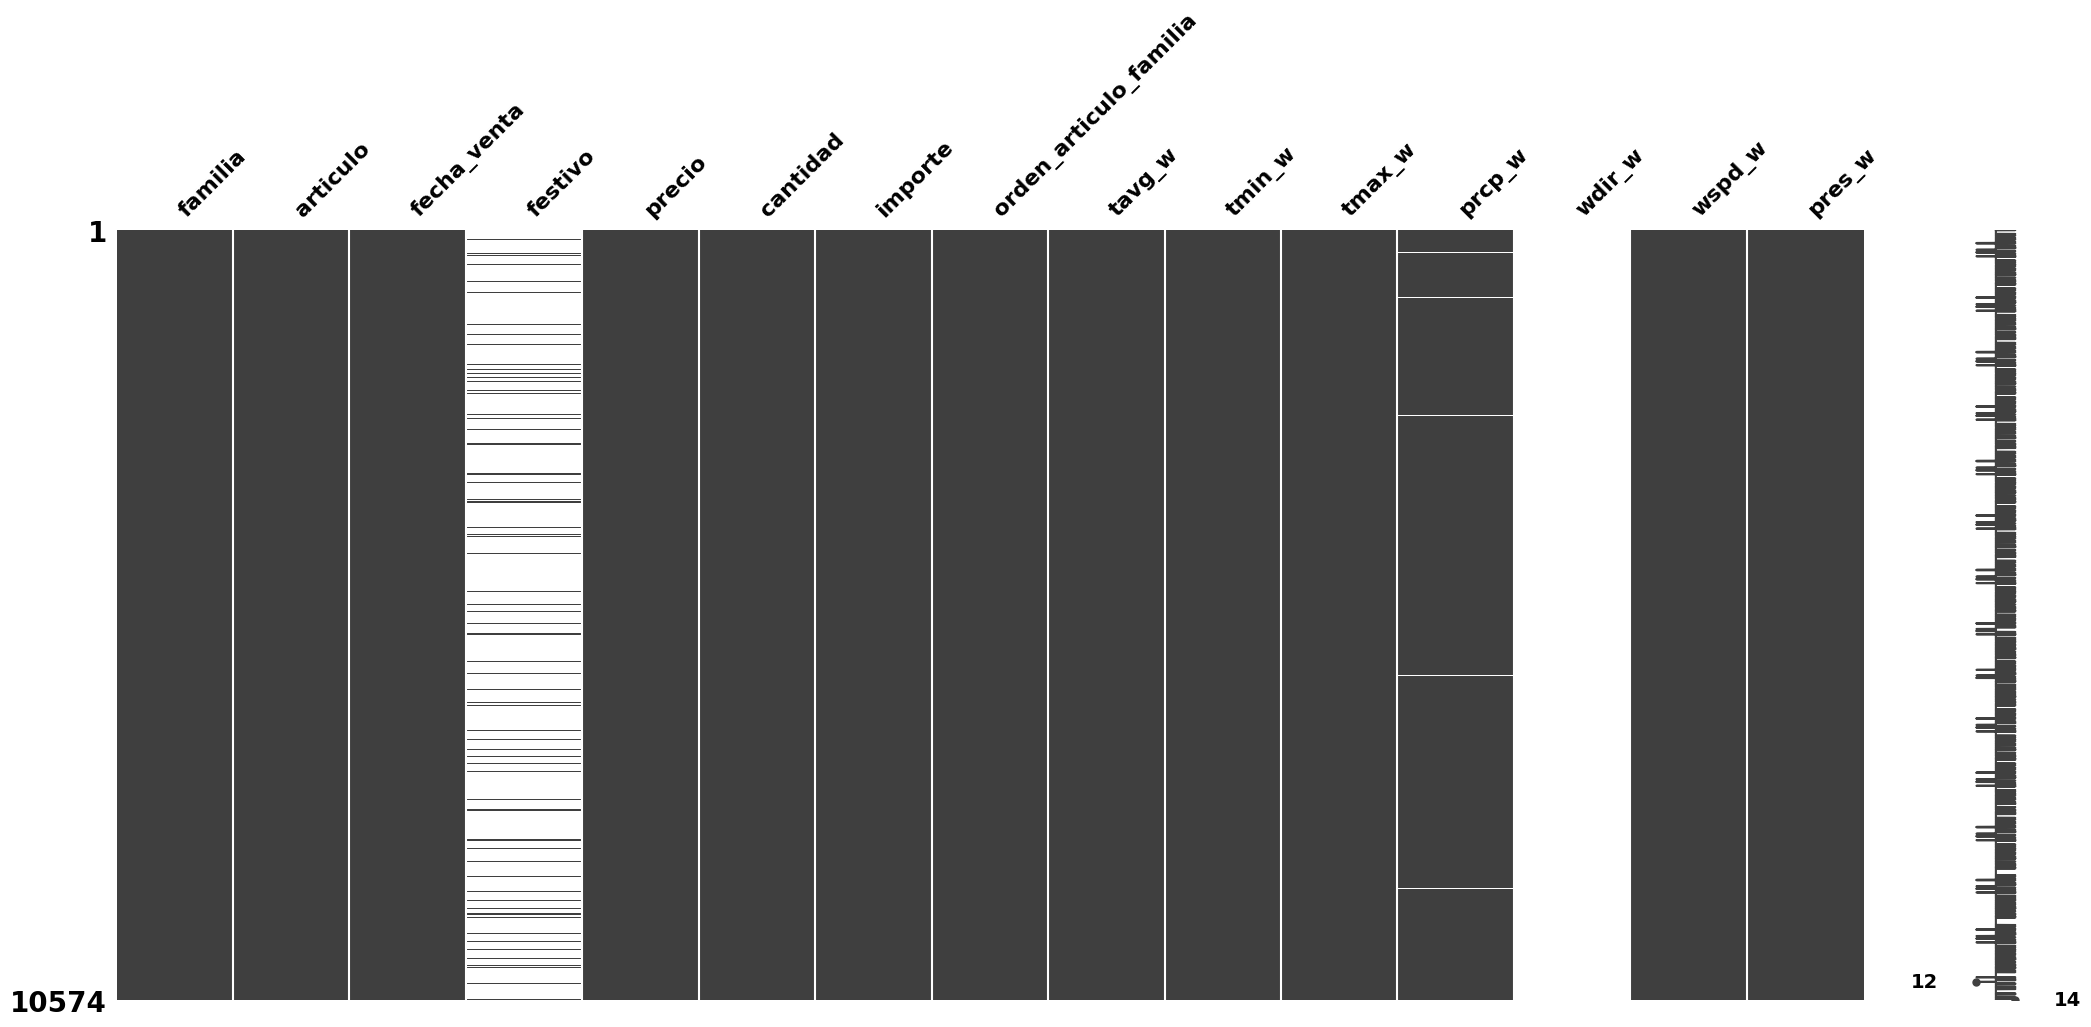

In [ ]:
# 3_Gráfica visual de valores nulos, tengo que usar el método .to_pandas
msno.matrix(df.to_pandas())

In [ ]:
# 4_Vamos a comprobar si hay duplicados
num_duplicated = df.is_duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicated}")

Número de filas duplicadas: 0


In [ ]:
# 4_Encuentra duplicados por varias columnas en Polars (sin argumento 'subset', solo los nombres de columnas)
# Creo una columna temporal que concatene fecha_venta y articulo
# Me está dando bastante problemas Polars
df_ext = df.with_columns(
    (pl.col("fecha_venta").cast(pl.Utf8) + "_" + pl.col("articulo").cast(pl.Utf8)).alias("fecha_articulo")
)

# Busco duplicados de la columna
duplicated_mask = df_ext["fecha_articulo"].is_duplicated()
# Filtro para ver solo las filas duplicadas
df_double = df_ext.filter(duplicated_mask)

# Visualizo sin la columna temporal
print(df_double.drop("fecha_articulo"))


shape: (0, 15)
┌─────────┬──────────┬─────────────┬─────────┬───┬────────┬────────┬────────┬────────┐
│ familia ┆ articulo ┆ fecha_venta ┆ festivo ┆ … ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---     ┆ ---      ┆ ---         ┆ ---     ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ str     ┆ i64      ┆ date        ┆ str     ┆   ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞═════════╪══════════╪═════════════╪═════════╪═══╪════════╪════════╪════════╪════════╡
└─────────┴──────────┴─────────────┴─────────┴───┴────────┴────────┴────────┴────────┘


Al buscar filas duplicadas por las columnas "fecha_venta" y "articulo", el DataFrame resultante está vacío. Por tanto, podemos afirmar que no existen duplicados para esta combinación de claves.


In [26]:
# Voy a definir los tipos númericos, ya que polars no tiene el método "is_numeric_dtype"

# (Me estoy empezando a arrepentir de usar Polars)

# Num. types
numeric_types = [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]

# Pruebo la definición
numeric_cols = [col for col in df.columns if df[col].dtype in numeric_types]
df.select(numeric_cols).describe()

statistic,articulo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",10574.0,10574.0,10574.0,10574.0,10574.0,10574.0,10574.0,10574.0,10477.0,0.0,10574.0,10574.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,10574.0,0.0,0.0
"""mean""",3945.091734,15.414053,963.815672,3237.645557,2.961982,19.39129,15.222035,24.909504,0.793118,null,14.323492,1018.015992
"""std""",2404.630373,17.003998,1037.151996,1919.085207,1.395454,5.349137,5.506365,5.931939,4.279853,null,5.313389,5.113184
"""min""",417.0,0.865,8.4,63.0,1.0,7.3,1.1,13.3,0.0,null,6.1,1004.4
"""25%""",1043.0,2.591,105.0,2014.950019,2.0,14.6,10.9,19.7,0.0,null,10.9,1014.5
"""50%""",5403.0,3.545,588.0,2835.0,3.0,19.4,14.7,24.7,0.0,null,12.5,1017.2
"""75%""",6286.0,34.091,1533.0,3987.620693,4.0,23.8,19.9,29.6,0.0,null,16.8,1021.0
"""max""",6549.0,43.5,7770.0,22903.509735,5.0,33.5,27.5,42.6,46.8,null,46.5,1032.8


In [27]:
# Resumen de los datos, he necesitado pasarlo todo a String, si no daba error ya que Polars es bastante exigente con los tipos


summary_dict = {
    "Columna": [str(col) for col in df.columns],
    "Tipo": [str(df[col].dtype) for col in df.columns],
    "Cardinalidad": [str(df[col].n_unique()) for col in df.columns],
    "Granularidad (%)": [str(round(df[col].n_unique() / df.height * 100, 2)) for col in df.columns],
    "Nulos_Pct (%)": [str(round(df[col].null_count() /df.height * 100, 2)) for col in df.columns],
    "Max": [str(df[col].max()) if df[col].dtype in numeric_types else None for col in df.columns],
    "Min": [str(df[col].min()) if df[col].dtype in numeric_types else None for col in df.columns]
}

summary = pl.DataFrame(summary_dict)

summary

Columna,Tipo,Cardinalidad,Granularidad (%),Nulos_Pct (%),Max,Min
str,str,str,str,str,str,str
"""familia""","""String""","""3""","""0.03""","""0.0""",null,null
"""articulo""","""Int64""","""15""","""0.14""","""0.0""","""6549""","""417"""
"""fecha_venta""","""Date""","""748""","""7.07""","""0.0""",null,null
"""festivo""","""String""","""27""","""0.26""","""92.08""",null,null
"""precio""","""Float64""","""65""","""0.61""","""0.0""","""43.5""","""0.8650000095367432"""
…,…,…,…,…,…,…
"""tmax_w""","""Float64""","""221""","""2.09""","""0.0""","""42.6""","""13.3"""
"""prcp_w""","""Float64""","""60""","""0.57""","""0.92""","""46.8""","""0.0"""
"""wdir_w""","""Float64""","""1""","""0.01""","""100.0""","""None""","""None"""


**Grupo de preguntas 2** (x minutos):

5. ¿Cuál es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¿hay fechas faltantes? Crea un gráfico de evolución temporal para la variable "cantidad" que muestre el producto "6549".

6. Separando por producto, ¿hay outliers en la variable "cantidad"?

In [ ]:
# 5_Recordar rango de fechas
print(df["fecha_venta"].min(), df["fecha_venta"].max())

print(f"Fecha mínima: {df['fecha_venta'].min()}")
print(f"Fecha máxima: {df['fecha_venta'].max()}")



2021-05-01 2023-05-18
Fecha mínima: 2021-05-01
Fecha máxima: 2023-05-18


In [29]:
# Comprobar si hay fechas faltantes por producto

all_dates = pl.date_range(
    start=df["fecha_venta"].min(),
    end=df["fecha_venta"].max(),
    interval="1d",
    eager=True
)

# Función para ver fechas faltantes para cada producto
id_product = 6549
product_date = df.filter(pl.col("articulo") == id_product)["fecha_venta"].unique()
missing_date = set(all_dates.to_list()) - set(product_date.to_list())

print(f"Fechas faltantes para el producto {id_product}:")
print(sorted(missing_date))
print(f"Total días sin datos: {len(missing_date)}")




Fechas faltantes para el producto 6549:
[datetime.date(2021, 5, 3), datetime.date(2021, 5, 4), datetime.date(2021, 5, 5), datetime.date(2021, 5, 6), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 18), datetime.date(2021, 5, 19), datetime.date(2021, 5, 20), datetime.date(2021, 5, 25), datetime.date(2021, 5, 26), datetime.date(2021, 6, 1), datetime.date(2021, 6, 2), datetime.date(2021, 6, 7), datetime.date(2021, 6, 8), datetime.date(2021, 6, 10), datetime.date(2021, 6, 15), datetime.date(2021, 6, 16), datetime.date(2021, 6, 17), datetime.date(2021, 7, 1), datetime.date(2021, 7, 8), datetime.date(2021, 7, 12), datetime.date(2021, 7, 13), datetime.date(2021, 7, 14), datetime.date(2021, 7, 19), datetime.date(2021, 7, 22), datetime.date(2021, 7, 28), datetime.date(2021, 7, 29), datetime.date(2021, 8, 2), datetime.date(2021, 8, 3), datetime.date(2021, 8, 4), datetime.date(2021, 8, 5), datetime.date(2021, 8, 17), datetime.date(2021, 8, 18), datetime.date(2021, 8

In [46]:
# Hecha la anterior celda, con la función para un producto, haré la función para todos los productos
full_dates = pl.date_range(
    start=df["fecha_venta"].min(),
    end=df["fecha_venta"].max(),
    interval="1d",
    eager=True
).to_list()

# Lista de productos únicos
products = df["articulo"].unique().to_list()

# Dict para guardar fechas faltantes
missing_dates = {}

for prod in products:
    prod_dates = df.filter(pl.col("articulo") == prod)["fecha_venta"].unique().to_list()
    missing = sorted(set(full_dates) - set(prod_dates))
    if missing:  # Solo debería guardar si faltan fechas
        missing_dates[prod] = missing

# Muestra resultado resumido
print(f"Productos con fechas faltantes: {len(missing_dates)} de {len(products)} productos\n")
for prod, missing in missing_dates.items():
    print(f"Producto {prod}: {len(missing)} fechas faltantes")




Productos con fechas faltantes: 8 de 15 productos

Producto 5403: 107 fechas faltantes
Producto 5404: 98 fechas faltantes
Producto 5803: 3 fechas faltantes
Producto 6286: 2 fechas faltantes
Producto 6425: 1 fechas faltantes
Producto 6451: 74 fechas faltantes
Producto 6523: 49 fechas faltantes
Producto 6549: 312 fechas faltantes


In [31]:
# Para ver fechas concretas para cada uno
example = list(missing_dates.keys())[0] if missing_dates else None
if example:
    print(f"\nFechas faltantes para el producto {example}:")
    print(missing_dates[example])


Fechas faltantes para el producto 5403:
[datetime.date(2021, 5, 13), datetime.date(2021, 5, 19), datetime.date(2021, 5, 25), datetime.date(2021, 5, 27), datetime.date(2021, 6, 2), datetime.date(2021, 6, 15), datetime.date(2021, 6, 17), datetime.date(2021, 6, 29), datetime.date(2021, 7, 7), datetime.date(2021, 7, 20), datetime.date(2021, 8, 3), datetime.date(2021, 8, 12), datetime.date(2021, 8, 13), datetime.date(2021, 10, 13), datetime.date(2021, 10, 25), datetime.date(2021, 10, 27), datetime.date(2021, 11, 8), datetime.date(2021, 11, 18), datetime.date(2021, 11, 23), datetime.date(2021, 11, 25), datetime.date(2021, 12, 2), datetime.date(2021, 12, 9), datetime.date(2021, 12, 12), datetime.date(2021, 12, 14), datetime.date(2021, 12, 15), datetime.date(2022, 1, 5), datetime.date(2022, 1, 6), datetime.date(2022, 1, 7), datetime.date(2022, 1, 18), datetime.date(2022, 1, 28), datetime.date(2022, 2, 2), datetime.date(2022, 2, 9), datetime.date(2022, 2, 14), datetime.date(2022, 2, 15), datet

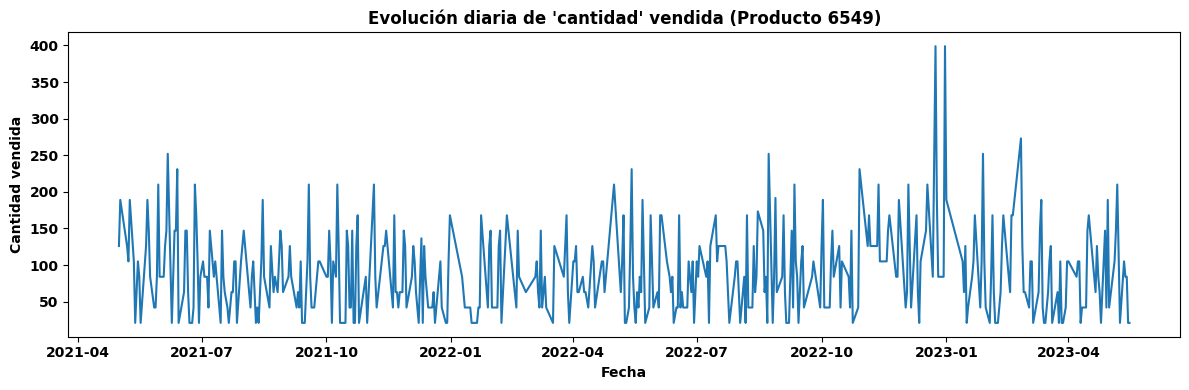

In [72]:
PLOTS_EDA_DIR = r"d:\PersonalProjects\Panadería Datathon\outputs\plots\eda"

# Gráfico de evolución temporal para el producto 6549

# Filtro datos del producto y los ordeno por fecha
df_6549 = df.filter(pl.col("articulo") == 6549).sort("fecha_venta")

# Ploteo
plt.figure(figsize=(12, 4))
plt.plot(df_6549["fecha_venta"].to_pandas(), df_6549["cantidad"].to_pandas())
plt.title("Evolución diaria de 'cantidad' vendida (Producto 6549)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "daily_evolution_sold_6549"))
plt.show()

In [ ]:
# 6_Outliers, calculo Q1, Q3, IQR
q1 = df_6549["cantidad"].quantile(0.25)
q3 = df_6549["cantidad"].quantile(0.75)
iqr = q3 - q1
lim_sup = q3 + 1.5 * iqr
lim_inf = q1 - 1.5 * iqr

# Filtrar outliers
outliers_6549 = df_6549.filter(
    (pl.col("cantidad") < lim_inf) | (pl.col("cantidad") > lim_sup)
)

print(f"Número de outliers para el producto 6549: {outliers_6549.shape[0]}")
outliers_6549

Número de outliers para el producto 6549: 3


familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,i64,date,str,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""PASTELERIA""",6549,2022-12-24,"""Nochebuena""",32.591,399.0,13003.809349,5,13.7,10.1,19.8,0.0,null,10.5,1023.3
"""PASTELERIA""",6549,2022-12-31,"""Nochevieja""",32.591,399.0,13003.808975,5,11.4,5.2,20.5,0.0,null,12.4,1027.2
"""PASTELERIA""",6549,2023-02-25,null,32.591,273.0,8897.343185,5,10.6,6.8,16.3,0.0,null,11.5,1009.2


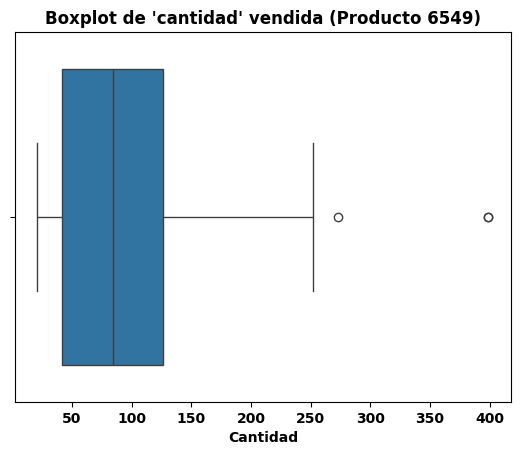

In [73]:
# Boxplot para ver outliers, hay que pasarlo a pandas también
import seaborn as sns

sns.boxplot(x=df_6549["cantidad"].to_pandas())
plt.title("Boxplot de 'cantidad' vendida (Producto 6549)")
plt.xlabel("Cantidad")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "boxplot_6549"), dpi=300)
plt.show()




In [35]:
# Mostramos valores de esos outliers
print(outliers_6549[["fecha_venta", "cantidad"]])

shape: (3, 2)
┌─────────────┬──────────┐
│ fecha_venta ┆ cantidad │
│ ---         ┆ ---      │
│ date        ┆ f64      │
╞═════════════╪══════════╡
│ 2022-12-24  ┆ 399.0    │
│ 2022-12-31  ┆ 399.0    │
│ 2023-02-25  ┆ 273.0    │
└─────────────┴──────────┘


In [ ]:
# Vamos a intentar hacer una función que detecte todos los outliers del dataset

def get_outliers_product(df, columna_producto="articulo", columna_valor="cantidad"):
    outliers_list = []
    products = df[columna_producto].unique().to_list()

    for prod in products:
        subdf = df.filter(pl.col(columna_producto) == prod)
        if subdf.shape[0] < 5:
            continue   # Ignora productos con pocos datos

        q1 = subdf[columna_valor].quantile(0.25)
        q3 = subdf[columna_valor].quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 - 1.5 * iqr

        outliers = subdf.filter((pl.col(columna_valor) < lim_inf) | (pl.col(columna_valor) > lim_sup))
        if outliers.shape[0] > 0:
            outliers_list.append(outliers)

    if outliers_list:
        return pl.concat(outliers_list)
    else:
        return pl.DataFrame([])
    
# Probamos la función
all_outliers = get_outliers_product(df)
print(f"Número total de outliers en todo el dataset: {all_outliers.shape[0]}")
all_outliers.head()

Número total de outliers en todo el dataset: 9853


familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,i64,date,str,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""PANADERIA""",417,2021-05-01,null,4.038,504.0,2035.152027,5,17.2,11.9,22.8,0.0,null,14.2,1014.0
"""PANADERIA""",417,2021-05-02,"""Día de la Madre""",4.038,567.0,2289.545967,5,16.3,10.8,23.2,0.0,null,15.7,1015.9
"""PANADERIA""",417,2021-05-03,"""Día de la Cruz""",4.038,630.0,2543.939987,5,15.3,12.7,20.1,6.5,null,9.7,1017.7
"""PANADERIA""",417,2021-05-04,null,4.038,588.0,2374.344009,5,16.5,12.0,20.9,0.0,null,12.1,1018.0
"""PANADERIA""",417,2021-05-05,null,4.038,588.0,2374.344023,5,16.7,12.3,21.7,0.0,null,13.8,1016.5


In [ ]:
# Porcentaje total de outliers en el dataset 
print(f"Porcentaje de outliers: {100 * all_outliers.shape[0] / df.shape[0]:.2f}%")


Porcentaje de outliers: 93.18%


### Sobre los outliers detectados en "cantidad"

Al aplicar el método clásico de outliers (usando el rango intercuartílico o IQR), hemos visto que más del **90% de las observaciones** son marcadas como outliers. Esto no significa necesariamente que haya errores en los datos, sino que la distribución de "cantidad" es **muy desigual**. En ventas reales es habitual encontrar:

- Muchos días con ventas cero (lo que estrecha el IQR).
- Días puntuales con pedidos altos por promociones, eventos o simplemente variabilidad normal.
- Grandes diferencias entre productos (algunos con ventas constantes y otros casi nunca).

Por eso, el método IQR clásico se vuelve **demasiado sensible** en este contexto y marca como outlier la mayoría de las ventas.  
En estos casos, conviene revisar los datos visualmente y, si es necesario, ajustar el método (por ejemplo, usando un umbral más amplio, percentiles, o solo revisando los casos extremos).

La mayoría de estos "outliers" probablemente sean ventas válidas y reflejan la realidad de los datos, no errores.**


In [37]:
# Función para contar outliers por producto (usando 1.5 x IQR)
def count_outliers_per_product(df, columna_producto="articulo", columna_valor="cantidad"):
    summary = []
    products = df[columna_producto].unique().to_list()
    for prod in products:
        subdf = df.filter(pl.col(columna_producto) == prod)
        if subdf.shape[0] < 5:
            continue
        q1 = subdf[columna_valor].quantile(0.25)
        q3 = subdf[columna_valor].quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr
        n_outliers = subdf.filter((pl.col(columna_valor) < lim_inf) | (pl.col(columna_valor) > lim_sup)).shape[0]
        summary.append({"articulo": prod, "outliers_cantidad": n_outliers, "n_total": subdf.shape[0]})
    return pl.DataFrame(summary)

# Ejecuto y muestro la tabla
table_outliers = count_outliers_per_product(df)
table_outliers = table_outliers.with_columns(
    (pl.col("outliers_cantidad") / pl.col("n_total") * 100).alias("porcentaje_outliers")
)
table_outliers = table_outliers.sort("porcentaje_outliers", descending=True)

print(table_outliers)


shape: (15, 4)
┌──────────┬───────────────────┬─────────┬─────────────────────┐
│ articulo ┆ outliers_cantidad ┆ n_total ┆ porcentaje_outliers │
│ ---      ┆ ---               ┆ ---     ┆ ---                 │
│ i64      ┆ i64               ┆ i64     ┆ f64                 │
╞══════════╪═══════════════════╪═════════╪═════════════════════╡
│ 6286     ┆ 59                ┆ 746     ┆ 7.908847            │
│ 5803     ┆ 53                ┆ 745     ┆ 7.114094            │
│ 5403     ┆ 37                ┆ 641     ┆ 5.772231            │
│ 6523     ┆ 36                ┆ 699     ┆ 5.150215            │
│ 3880     ┆ 38                ┆ 748     ┆ 5.080214            │
│ …        ┆ …                 ┆ …       ┆ …                   │
│ 6425     ┆ 25                ┆ 747     ┆ 3.34672             │
│ 417      ┆ 19                ┆ 748     ┆ 2.540107            │
│ 3960     ┆ 15                ┆ 748     ┆ 2.005348            │
│ 6549     ┆ 3                 ┆ 436     ┆ 0.688073            │
│ 1084    

In [38]:
# Miro los 5 productos con mayor porcentaje de outliers
top_5_outliers = table_outliers.head(5)

print("Top 5 productos con mayor % de outliers en 'cantidad':")
print(top_5_outliers)


Top 5 productos con mayor % de outliers en 'cantidad':
shape: (5, 4)
┌──────────┬───────────────────┬─────────┬─────────────────────┐
│ articulo ┆ outliers_cantidad ┆ n_total ┆ porcentaje_outliers │
│ ---      ┆ ---               ┆ ---     ┆ ---                 │
│ i64      ┆ i64               ┆ i64     ┆ f64                 │
╞══════════╪═══════════════════╪═════════╪═════════════════════╡
│ 6286     ┆ 59                ┆ 746     ┆ 7.908847            │
│ 5803     ┆ 53                ┆ 745     ┆ 7.114094            │
│ 5403     ┆ 37                ┆ 641     ┆ 5.772231            │
│ 6523     ┆ 36                ┆ 699     ┆ 5.150215            │
│ 3880     ┆ 38                ┆ 748     ┆ 5.080214            │
└──────────┴───────────────────┴─────────┴─────────────────────┘


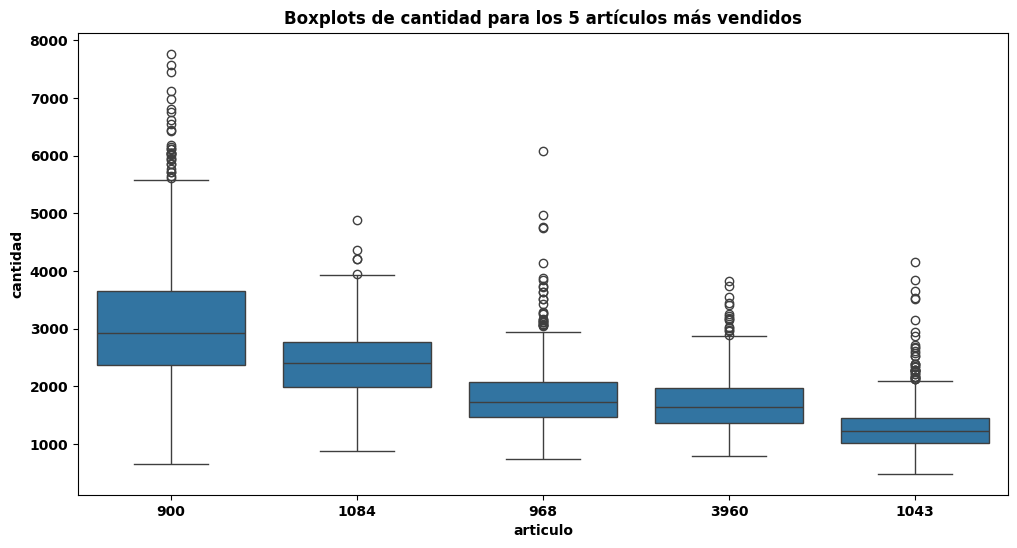

In [74]:
# Vamos a visualizar más Boxplots para los productos top
top_items = df.group_by("articulo").agg(pl.col("cantidad").sum()).sort("cantidad", descending=True)["articulo"].to_list()[:5]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=pd.concat([df.filter(pl.col("articulo") == art).select(["cantidad"]).to_pandas().assign(articulo=str(art)) for art in top_items]),
    x="articulo",
    y="cantidad"
)
plt.title("Boxplots de cantidad para los 5 artículos más vendidos")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "boxplots_outliers_top5_products"), dpi=300)
plt.show()

### Boxplot de cantidades para los 5 artículos más vendidos
El gráfico muestra la dispersión diaria de ventas para los cinco productos más vendidos.
Se aprecian diferencias de escala y numerosos outliers, lo que indica días con ventas anómalamente altas.
Este análisis ayuda a identificar variabilidad y detectar posibles anomalías en los datos de ventas.

#### 4.2. Análisis de la variable a predecir

Este apartado tiene como cometido comprender la evolución de la variable "cantidad" en el tiempo y como se relaciona esta consigo misma.

**Grupo de preguntas 3** (x minutos):

7. Crea un gráfico de la evolución temporal general de la variable "cantidad". Nota: Se debe de agrupar.

8. Crea un gráfico de la evolución temporal por familia de la variable "cantidad". Nota: Se debe de agrupar.

9. Crea un gráfico de la evolución temporal por artículo de la variable "cantidad". Nota: Se debe de agrupar.

10. Se que hay mucho ruido, pero ¿a simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

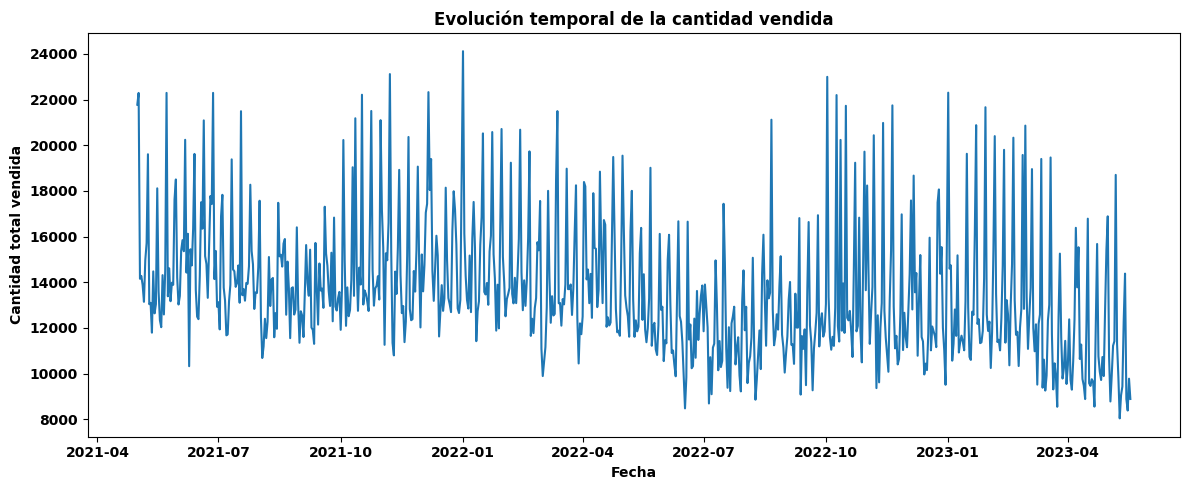

In [75]:
# 7_Evolución temporal general de la variable "cantidad"

# Voy a agrupar por fecha y sumo la cantidad total vendida cada día
quantity_evo = (
    df.group_by("fecha_venta")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("fecha_venta")
)

# Paso a pandas para el plotting
plt.figure(figsize=(12, 5))
plt.plot(quantity_evo["fecha_venta"].to_pandas(), quantity_evo["cantidad_total"].to_pandas())
plt.title("Evolución temporal de la cantidad vendida")
plt.xlabel("Fecha")
plt.ylabel("Cantidad total vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_quantity_sales"), dpi=300)
plt.show()

#### Evolución temporal de la cantidad vendida

El gráfico muestra la evolución diaria de la cantidad total vendida en la panadería durante el periodo analizado.  
Se aprecia bastante ruido en las ventas diarias y no se observa una tendencia clara a simple vista, aunque podría haber patrones estacionales o picos puntuales.  
Este comportamiento es habitual en negocios minoristas, donde factores como la demanda variable o eventos especiales afectan la serie temporal.


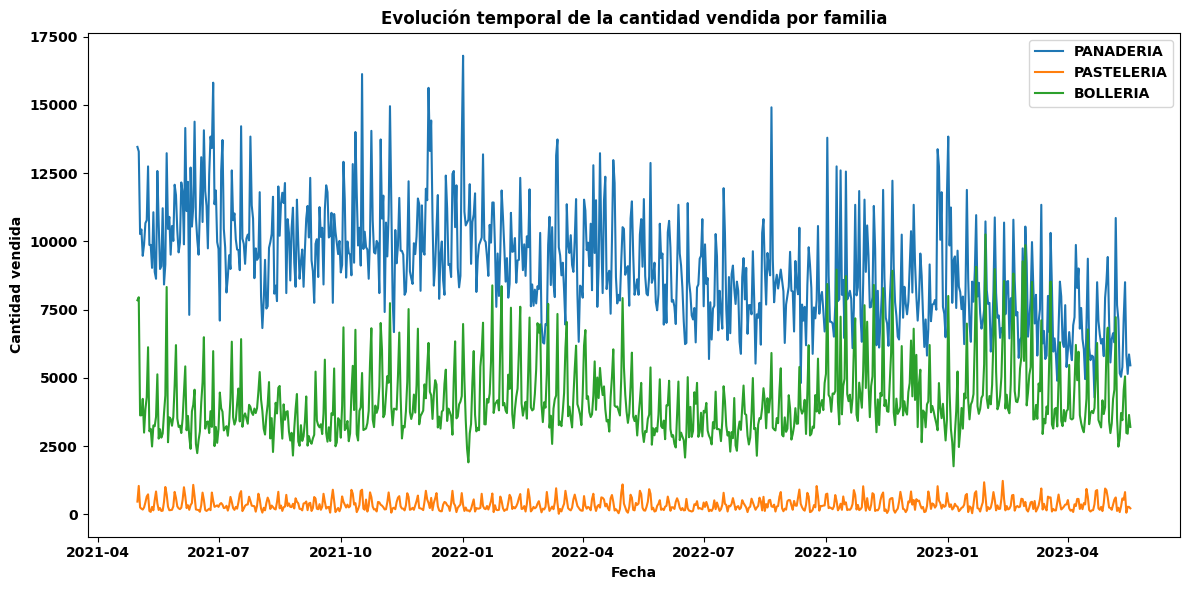

In [78]:
# 8_Evolución temporal por familia de la variable "cantidad"

# Agrupar por fecha y familia
agg_familia = (
    df.group_by(["fecha_venta", "familia"])
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort(["familia", "fecha_venta"])
)

familias = agg_familia["familia"].unique().to_list()

plt.figure(figsize=(12, 6))
for fam in familias:
    data = agg_familia.filter(pl.col("familia") == fam)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), label=fam)
plt.title("Evolución temporal de la cantidad vendida por familia")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_sales_per_family"), dpi=300)
plt.show()   

#### Evolución temporal de la cantidad vendida por familia

La gráfica muestra cómo evoluciona la cantidad total vendida a lo largo del tiempo para cada familia de productos.  
Se observan diferencias claras en el volumen y el comportamiento de ventas según la familia, con algunas presentando más variabilidad o picos en fechas concretas.  
Este análisis ayuda a identificar patrones específicos y posibles oportunidades de mejora para cada línea de producto.

Destaca especialmente la familia PANADERÍA, que muestra un volumen de ventas mucho mayor y una mayor estabilidad/picos a lo largo del tiempo, en comparación con el resto de familias. Este comportamiento puede deberse a la popularidad del producto, promociones específicas, una mayor demanda en ciertos periodos, o simplemente que son productos disponibles cada día, a excepción de otros de las demás familias.


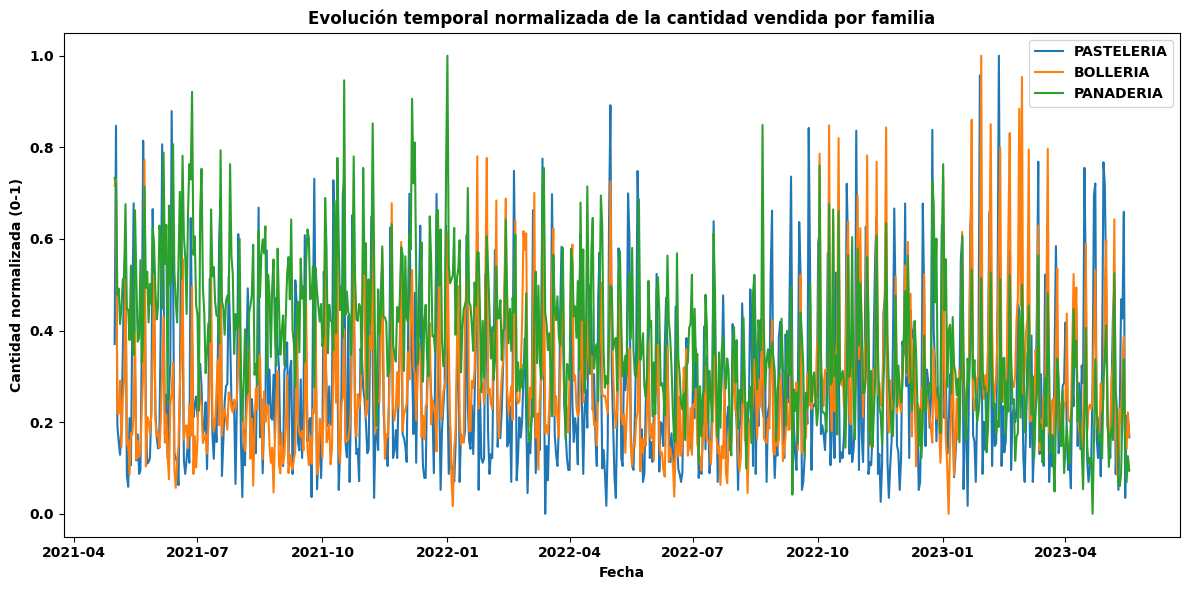

In [81]:
# Normalizamos la variable "cantidad", para una fácil comparación aunque tengan escalas muy diferents las familias
from sklearn.preprocessing import MinMaxScaler

# Primero agrupamos por familia y fecha (como antes)
agg_familia = (
    df.group_by(["fecha_venta", "familia"])
      .agg(pl.col("cantidad").sum().alias("cantidad_total"))
      .sort(["familia", "fecha_venta"])
)

# Normaliza la cantidad para cada familia (0-1)
result = []
for fam in agg_familia["familia"].unique().to_list():
    sub = agg_familia.filter(pl.col("familia") == fam)
    scaler = MinMaxScaler()
    cantidades_norm = scaler.fit_transform(sub["cantidad_total"].to_numpy().reshape(-1,1)).flatten()
    temp_df = sub.with_columns([
        pl.Series("cantidad_norm", cantidades_norm)
    ])
    result.append(temp_df)

agg_norm = pl.concat(result)

# Plot
plt.figure(figsize=(12,6))
for fam in agg_norm["familia"].unique().to_list():
    datos = agg_norm.filter(pl.col("familia") == fam)
    plt.plot(datos["fecha_venta"].to_pandas(), datos["cantidad_norm"].to_pandas(), label=fam)
plt.title("Evolución temporal normalizada de la cantidad vendida por familia")
plt.xlabel("Fecha")
plt.ylabel("Cantidad normalizada (0-1)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_sales_scaler_per_family"), dpi=300)
plt.show()


#### Evolución temporal normalizada de la cantidad vendida por familia

En este gráfico, la cantidad vendida por cada familia de productos se ha normalizado entre 0 y 1, para facilitar la comparación de patrones y tendencias independientemente del volumen de ventas. 

La normalización permite observar similitudes o diferencias en la evolución relativa de cada familia a lo largo del tiempo, destacando posibles efectos estacionales o comportamientos sincronizados entre productos.

> **Interpretación de la evolución temporal normalizada por familia:**  
> 
> Las tres familias (PASTELERIA, BOLLERIA y PANADERIA) presentan una evolución diaria con mucha variabilidad y sin una tendencia clara a largo plazo.  
> No se observan picos sincronizados fuertes ni patrones de estacionalidad evidentes entre las familias: sus máximos y mínimos aparecen en fechas distintas.  
> La demanda parece estar influida más por factores específicos de cada producto que por patrones generales o estacionales.  
> En resumen, cada familia evoluciona de forma relativamente independiente y con bastante ruido día a día.



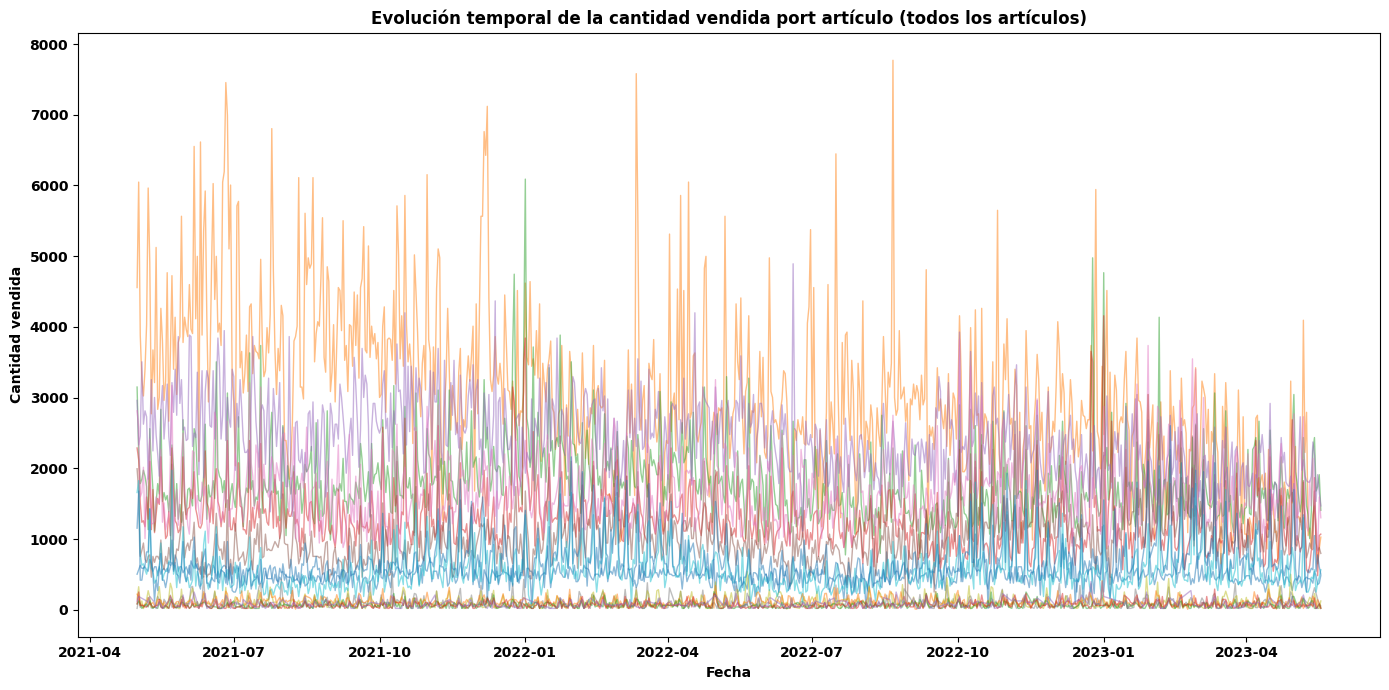

In [86]:
# 9_Evolución temporal por artículo de la variable "cantidad"

# Agrupar por fecha y artículo
agg_articulos = (
    df.group_by(["fecha_venta", "articulo"])
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort(["articulo", "fecha_venta"])
)

# Artículos únicos
all_items = agg_articulos["articulo"].unique().to_list()

# Plotting
plt.figure(figsize=(14, 7))
for item in all_items:
    data = agg_articulos.filter(pl.col("articulo") == item)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), alpha=0.5, linewidth=1)
plt.title("Evolución temporal de la cantidad vendida port artículo (todos los artículos)") 
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_sales_per_item"), dpi=300)
plt.show()



### Evolución temporal de la cantidad vendida por artículo

En este gráfico se representa la evolución diaria de la cantidad vendida para **cada artículo** del catálogo. Cada línea corresponde a un artículo distinto.

Como era de esperar, el gráfico muestra un alto nivel de ruido visual debido al gran número de artículos representados, lo que hace que resulte difícil identificar patrones concretos para productos individuales. Sin embargo, esta visualización global es útil para hacerse una idea general del comportamiento conjunto, detectar picos generales de demanda o posibles anomalías a nivel agregado.

> **Nota:** Por motivos de claridad, no se ha incluido una leyenda para cada artículo, ya que haría el gráfico ilegible. Para un análisis más detallado, es recomendable seleccionar artículos concretos y analizar sus series de forma individual.


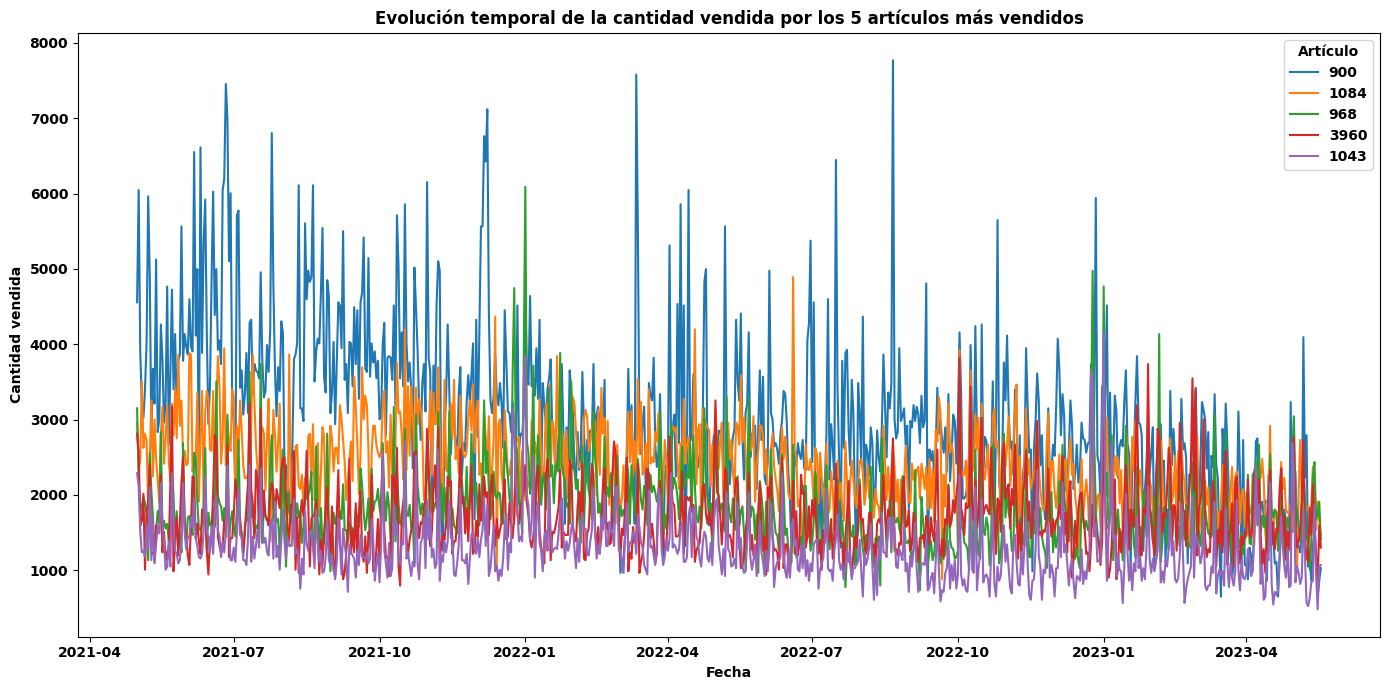

In [87]:
# Me voy a centrar en los artículos más vendidos para recibir un ploteo más limpio

# Top 5 artículos más vendidos
best_five_items = (
    df.group_by("articulo")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("cantidad_total", descending=True)
    .head(5)["articulo"]
    .to_list()
)

# Filtro con artículos top
df_top = df.filter(pl.col("articulo").is_in(best_five_items))

# Ploteo
plt.figure(figsize=(14, 7))
for item in best_five_items:
    data = agg_articulos.filter(pl.col("articulo") == item)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), label=str(item))
plt.title("Evolución temporal de la cantidad vendida por los 5 artículos más vendidos")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.legend(title="Artículo")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "total_sales_top5_items"), dpi=300)
plt.show()



### Evolución temporal de la cantidad vendida para los 5 artículos más vendidos

Este gráfico muestra la evolución diaria de la cantidad vendida para los cinco artículos más vendidos de la panadería.

Cada línea representa un artículo diferente, lo que permite comparar visualmente su comportamiento a lo largo del tiempo.  
Se observan **altos niveles de variabilidad** y picos pronunciados, lo que puede estar relacionado con la demanda estacional, promociones o eventos puntuales.

Este enfoque facilita detectar tendencias y posibles patrones para los productos más relevantes, a diferencia del gráfico global donde el exceso de líneas dificulta el análisis detallado.


### 10. ¿A simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

A simple vista, las series temporales analizadas muestran **mucho ruido** y una alta variabilidad diaria.  
No se aprecia una tendencia clara de aumento o descenso sostenido en la cantidad vendida para la mayoría de productos o familias.

Sin embargo, **sí parece haber cierta estacionalidad**: se observan repuntes y caídas recurrentes en varios periodos, especialmente en los productos más vendidos.  
Estas fluctuaciones podrían estar asociadas a fines de semana, festivos, campañas especiales o épocas del año concretas.

Para confirmar la presencia de tendencia o estacionalidad, sería recomendable aplicar técnicas estadísticas como la descomposición de series temporales o el análisis de autocorrelación.


**Grupo de preguntas 4** (x minutos):

11. Aplica alguna técnica estadística para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". Pista: Tomar la primera diferencia y, después, hacer un analisis de autocorrelación.

12. Sin aplicar la primera diferencia y creando nuevas columnas de fecha a partir de la variable "fecha_venta" (semana del año, mes del año, día de la semana, día del mes, día del año) comprueba realizando diferentes agrupaciones y gráficos si nuestro análisis de autocorrelación de nuestra variable cantidad nos mostraba lo correcto. Si encuentras algún gráfico que te llame la atención, baja el nivel del análisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por artículo).

In [ ]:
# 11
# Check si el proceso es estacionario

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

group = df.groupby([pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
check_stationarity(group["cantidad"])
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

In [ ]:
# 11
# Tomando la primera diferencia

# Podemos tomar la primera diferencia para observar si nuestra serie se convierte en estacionaria.
# Esto elimina tendencias y estabiliza la varianza de la serie, permitiendo que sea modelada.

group["cantidad_diff"] = group["cantidad"].diff().fillna(0)
check_stationarity(group["cantidad_diff"])

In [ ]:
# 11
# La nueva serie temporal tiene esta pinta

fig = px.line(group, x="fecha_venta", y="cantidad_diff")
fig.show()

In [ ]:
# 11
# Analisis de autocorrelación

# En terminos generales, este gráfico nos indica que un valor de cantidad esta
# directamente relacionado con su valor de cantidad anterior y su valor de cantidad de la semana pasada.
# Parece que hay estacionalidad semanal.

plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

In [ ]:
# 12

# Semana y mes del año
df["weekofyear"] = df["fecha_venta"].dt.isocalendar().week
df["monthofyear"] = df["fecha_venta"].dt.month

# Día de la semana, del mes y del año
df["dayofweek"] = df["fecha_venta"].dt.b #Lunes 0 y Domingo 6
df["dayofmonth"] = df["fecha_venta"].dt.day
df["dayofyear"] = df["fecha_venta"].dt.dayofyear

def graph_by_freq(freq, breakdown="familia", norm=False):
    group = df.groupby([breakdown, freq], as_index=False)["cantidad"].sum()

    if norm == True:
        group['cantidad'] = group.groupby(breakdown)['cantidad'].transform(normalize)

    fig = px.line(group, x=freq, y="cantidad", color=breakdown, markers=True)
    fig.show()

# A nivel familia
graph_by_freq("dayofweek")

# Como nos encontramos en nuestro análisis de autocorrelación,
# los valores de cantidad podrían tener una relación con su valor de la semana pasada
# debido a que hay un patrón de compra semanal que se repite en el tiempo.

In [ ]:
# 12

# A nivel articulo
graph_by_freq("dayofweek", "articulo")

In [ ]:
# 12
# Gráficos caja

fig = px.box(df, x="dayofweek", y="cantidad", color='familia')
fig.show()

In [ ]:
graph_by_freq("monthofyear")

*****

#### 4.3. Análisis de la variable a predecir frente al resto de variables

**Grupo de preguntas 5** (x minutos):

13. ¿El comportamiento de compra (la variable "cantidad") cuando es festivo es superior a cuando no lo es?

14. ¿El comportamiento de compra (la variable "cantidad") cuando llueve es superior a cuando no llueve?

15. Divide la variable "tavg_w" en quintiles y muestra con un gráfico de barras sí la variable "cantidad" es superior en alguno de sus quintiles.

In [ ]:
# 13

# 1 si es festivo, 0 si no lo es
df['es_festivo'] = df['festivo'].apply(lambda x: 0 if x is None else 1)

fig = px.box(df, x="es_festivo", y="cantidad", color='familia')
fig.show()

# El comportamiento de compra cuando es festivo parece ligeramente superior

In [ ]:
# 14

# 1 si llueve, 0 si no llueve
df["lluvia"] = np.where(df["prcp_w"] > 0, 1, 0)

fig = px.box(df, x="lluvia", y="cantidad", color='familia')
fig.show()

# Parece que la lluvia no es un impedimiento para comprar

In [ ]:
# 15

labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

df['quintiles_tavg_w'] = pd.qcut(df['tavg_w'], q=5, labels=labels_tavg)

group = df.groupby(["familia", "quintiles_tavg_w"])["cantidad"].sum().reset_index()
fig = px.bar(group, x='quintiles_tavg_w', y='cantidad', color="familia",barmode='group')
fig.show()

**Grupo de preguntas 6** (x minutos):

16. ¿Un incremento en el precio reduce la propensión a consumir de un artículo?

In [ ]:
# 16

def function_variations(x):
    list_unique = x.unique()
    len_list = len(list_unique)

    if len_list > 1:
        return 1
    else:
        return 0

group = df.groupby(["articulo",
                    pd.Grouper(key="fecha_venta", freq="1M"),
                    "familia"]).agg({"cantidad": "sum",
                                     "precio": function_variations}).reset_index()

group["precio"] = group.groupby("articulo")["precio"].transform("cumsum")
group["precio"] = group["precio"].astype(object)

fig = px.box(group, x="precio", y="cantidad", color='articulo')
fig.show()

# No es concluyente debido a que puede haber una tendencia negativa/positiva en el consumo general del articulo
# a lo largo del tiempo, pero es interesante observar como muchas veces si que tiene un impacto negativo
# (productos: 417, 1043, 1084, 3960, 5403).
# Podría ser también por la canibalización de nuevos productos a otros anteriores.

*****